# Information Retrieval System

____________________________________________


## CS6370-NLP Project
-----------------------------------------------------
### Team - 20
#### B Aditi   (mm19b020)
#### R Rishaab Karthik (mm19b046)

In [1]:
from util import *
from sentencesegmentation import *
from tokenisation import *
from stopwordremoval import *
from inflectionReduction import *
from informationretrieval import *
from evaluation import *

[nltk_data] Downloading package omw-1.4 to /home/rishaab/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/rishaab/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rishaab/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/rishaab/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
pq=[]
ss=SentenceSegmentation()
tk=Tokenization()
sr=StopwordRemoval()
st=InflectionReduction()
ir=InformationRetrieval()
eva=Evaluation()

### Read Queries

In [3]:

queries_json = json.load(open('./cranfield/'+ "cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json],[item["query"] for item in queries_json]


### Process queries

In [4]:
proc_queries=[]
for q in queries:
    ssq=ss.punkt(q)
    tkq=tk.pennTreeBank(ssq)
    srq=sr.fromList(tkq)
    stq=st.reduce(srq)
    proc_queries.append(stq)

### Read documents 

In [5]:

docs_json = json.load(open('./cranfield/' + "cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json],[item["body"] for item in docs_json]


### Process Documents

In [6]:
proc_docs=[]
for d in docs:
    ssd=ss.punkt(d)
    tkd=tk.pennTreeBank(ssd)
    srd=sr.fromList(tkd)
    std=st.reduce(srd)
    proc_docs.append(std)

### TF_IDF Matrix

In [7]:
tfidf_docs_df=ir.buildIndex(proc_docs,doc_ids)

In [8]:
tfidf_docs_df.shape

(1400, 6611)

In [9]:
tfidf_queries_df=ir.tfidfq(proc_queries)

### Latent Semantic analysis 

In [10]:
lsadocs,lsaw2v=ir.lsa_doc(tfidf_docs_df,500)

In [11]:
lsaqueries,lsaq2v=ir.lsa_query(tfidf_queries_df)

### Word2Vec Embedding on LSA

In [12]:
doc_lsa_w2v=ir.w2v(lsaw2v)

In [13]:
q_lsa_w2v=ir.w2v(lsaq2v)

### Word2Vec embedding standalone 

In [14]:
doc_w2v=ir.w2v(tfidf_docs_df)
q_w2v=ir.w2v(tfidf_queries_df)

### Different Models Evaluated 

In [15]:
doc_ord_mod1=ir.rank(doc_ids,tfidf_docs_df,tfidf_queries_df)

In [16]:
doc_ord_mod2=ir.rank(doc_ids,lsadocs,lsaqueries)

In [17]:
doc_ord_mod3=ir.rank(doc_ids,doc_lsa_w2v,q_lsa_w2v)

In [18]:
doc_ord_mod4=ir.rank(doc_ids,doc_w2v,q_w2v)

In [19]:
ev=Evaluation()


In [20]:
qrels = json.load(open('./cranfield/' + "cran_qrels.json", 'r'))[:]

### Plain VSM TF_IDF Model 

In [21]:
ev.meanAveragePrecision(doc_ord_mod1,query_ids,qrels,10)

/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


0.32691764858923683

### LSA Model 

In [22]:
ev.meanAveragePrecision(doc_ord_mod2,query_ids,qrels,10)

0.3328471536867305

### LSA + Word2Vec

In [23]:
ev.meanAveragePrecision(doc_ord_mod3,query_ids,qrels,10)

0.2512909672215898

### Word2Vec 

In [24]:
ev.meanAveragePrecision(doc_ord_mod4,query_ids,qrels,10)

0.20479112536927754

### Finding optimal number of components for LSA and LSA+Word2Vec based on MAP

In [25]:
def lsa_model(k):
    lsadocs=ir.lsa_doc(tfidf_docs_df,k)[0]
    lsaqueries=ir.lsa_query(tfidf_queries_df)[0]
    doc_ord=ir.rank(doc_ids,lsadocs,lsaqueries)
    return doc_ord,ev.meanAveragePrecision(doc_ord,query_ids,qrels,1)

In [26]:
def lsa_model2(k):
    lsadocs=ir.lsa_doc(tfidf_docs_df,k)[1]
    lsaqueries=ir.lsa_query(tfidf_queries_df)[1]
    lsa_w2v=ir.w2v(lsadocs)
    q_w2v=ir.w2v(lsaqueries)
    doc_ord=ir.rank(doc_ids,lsa_w2v,q_w2v)
    return doc_ord,ev.meanAveragePrecision(doc_ord,query_ids,qrels,1)

In [27]:
order=[]
MAP=[]
for i in range(100,3100,100):
    o,m = lsa_model(i)
    order.append(o)
    MAP.append(m)


/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this wil

/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this wil

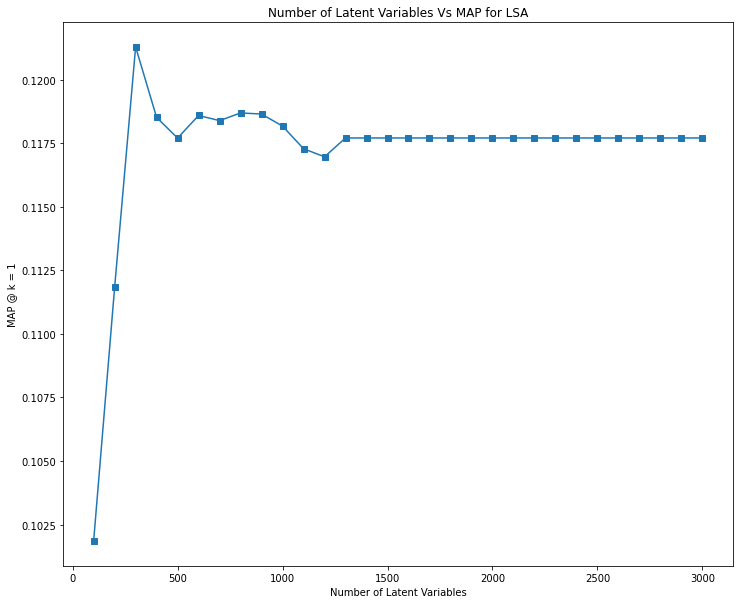

In [28]:
plt.figure(figsize=[12,10])
plt.plot(range(100,3100,100),MAP,'-s')
plt.title('Number of Latent Variables Vs MAP for LSA')
plt.xlabel('Number of Latent Variables')
plt.ylabel('MAP @ k = 1')
plt.show()

In [29]:
order2=[]
MAP2=[]
for i in range(100,3100,100):
    o,m = lsa_model2(i)
    order2.append(o)
    MAP2.append(m)


/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this wil

/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:
/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:32: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this wil

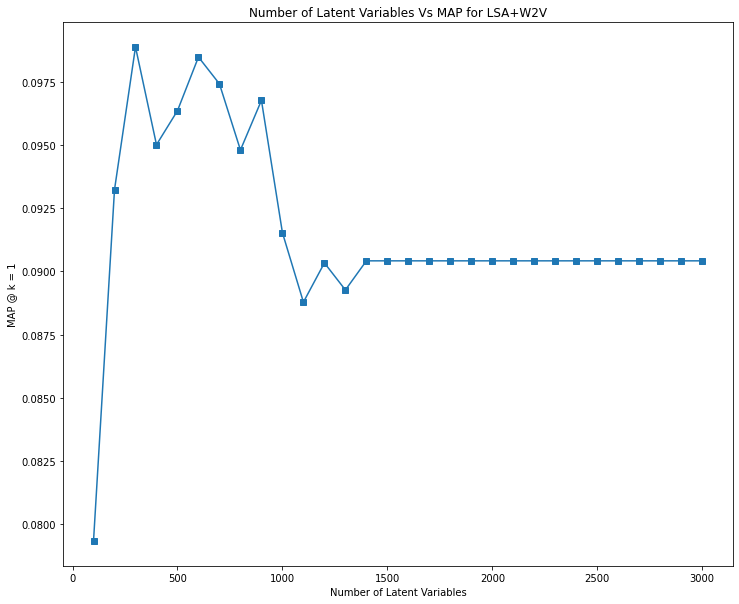

In [30]:
plt.figure(figsize=[12,10])
plt.plot(range(100,3100,100),MAP2,'-s')
plt.title('Number of Latent Variables Vs MAP for LSA+W2V')
plt.xlabel('Number of Latent Variables')
plt.ylabel('MAP @ k = 1')
plt.show()

### Functions to plot different Evaluation metrics

In [31]:
def eval_met(doc_ord_mod1):
    prec=[]
    meanap=[]
    meanFscore=[]
    meanrecall=[]
    nDCG=[]
    for i in range(1,20):
        prec.append(ev.meanPrecision(doc_ord_mod1,query_ids,qrels,i))
        meanap.append(ev.meanAveragePrecision(doc_ord_mod1,query_ids,qrels,i))
        meanFscore.append(ev.meanFscore(doc_ord_mod1,query_ids,qrels,i))
        meanrecall.append(ev.meanRecall(doc_ord_mod1,query_ids,qrels,i))
        nDCG.append(ev.meanNDCG(doc_ord_mod1,query_ids,qrels,i))
    model1=pd.DataFrame({'Precision':prec,'MaP':meanap,"meanFscore":meanFscore,'meanrecall':meanrecall,'MeanNDCG':nDCG})
    return model1

In [32]:
def plot_model(df,title):
    plt.figure(figsize=[12,10])
    for i in df.columns:
        plt.plot(range(1,20),df[i],label=i)
        plt.legend()
        plt.xlabel("k")
        plt.title(title)

### VSM-TF_IDF 

In [33]:
model1=eval_met(doc_ord_mod1)

/home/rishaab/Desktop/SEM8/CS6370/project/Code/evaluation.py:118: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for docID in query_doc_IDs_ordered[:k]:


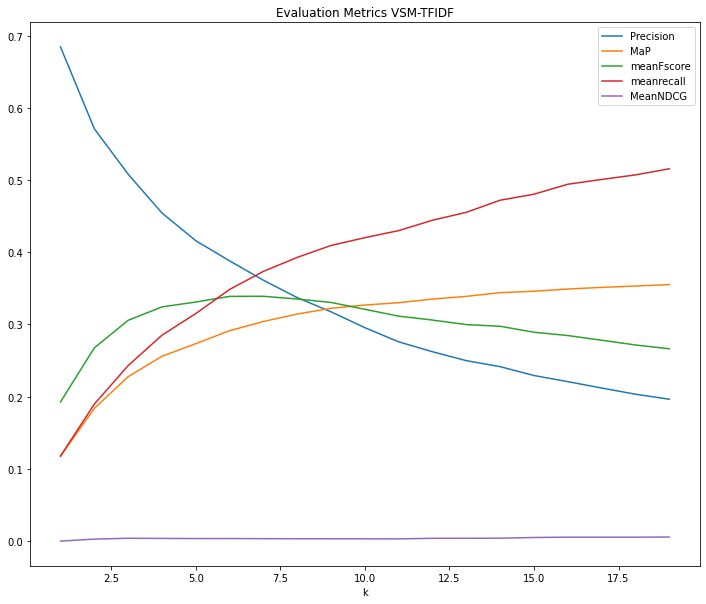

In [34]:
plot_model(model1,'Evaluation Metrics VSM-TFIDF')

###  LSA  

In [35]:
doc_ord_opt_lsa=order[2]
eval_model_opt_lsa=eval_met(doc_ord_opt_lsa)


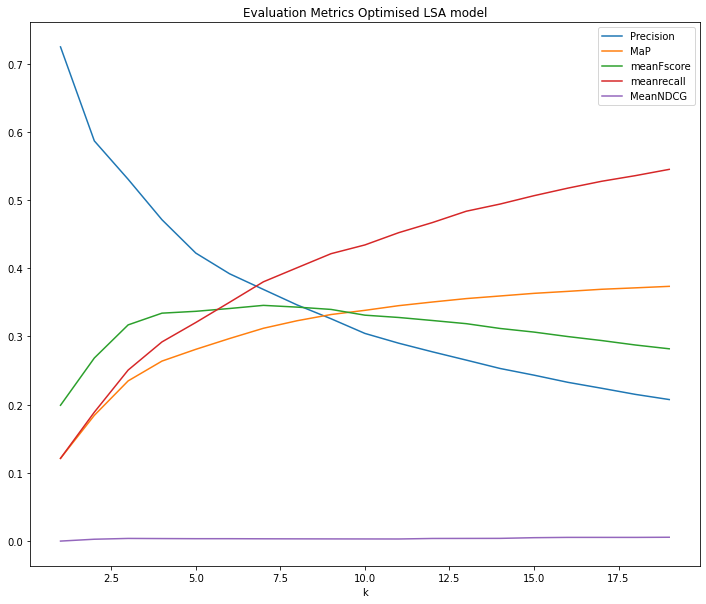

In [36]:
plot_model(eval_model_opt_lsa,'Evaluation Metrics Optimised LSA model')

### LSA + Word2Vec

In [37]:
eval_lsa_w2v_opt=eval_met(order2[2])


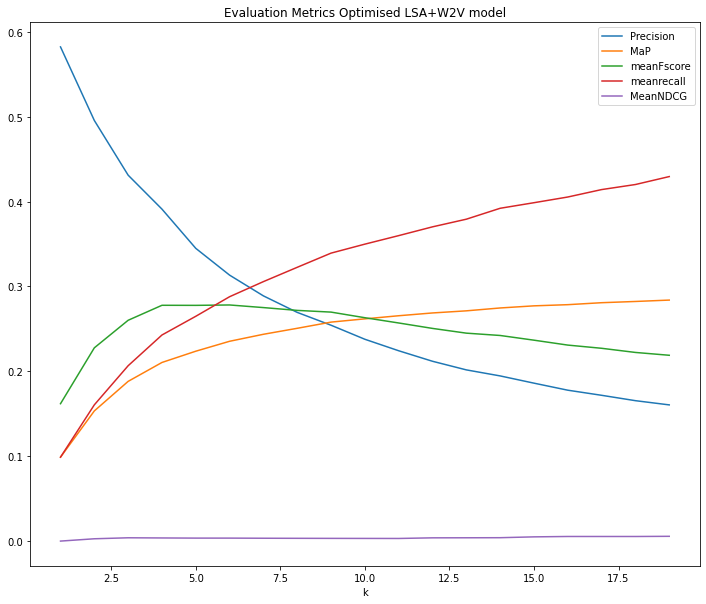

In [38]:
plot_model(eval_lsa_w2v_opt,'Evaluation Metrics Optimised LSA+W2V model')

### Word 2 Vec 

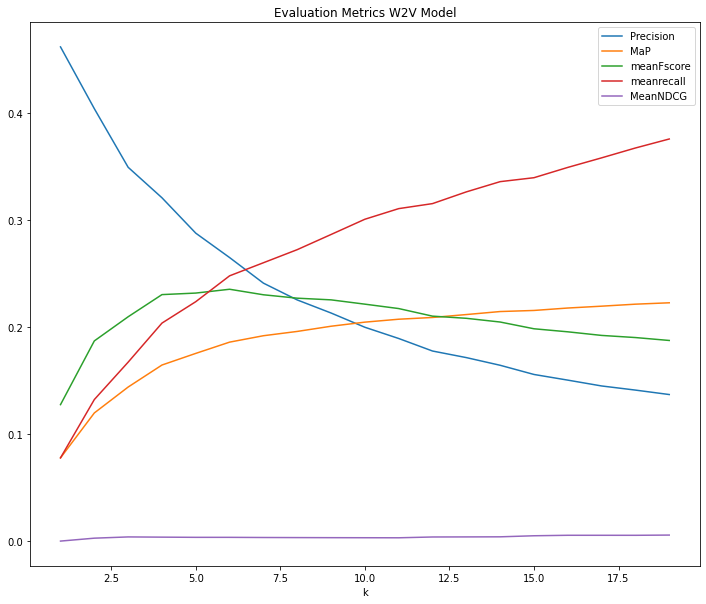

In [39]:
w2v_eval=eval_met(doc_ord_mod4)
plot_model(w2v_eval,'Evaluation Metrics W2V Model')

### Results

In [40]:
results=pd.concat([model1.iloc[9:10],eval_model_opt_lsa[9:10],eval_lsa_w2v_opt[9:10],w2v_eval[9:10]])
results['Model']=['TFIDF',"LSA","LSA+W2V","W2V"]
results.set_index('Model',inplace=True)

In [41]:
print('The Evaluation Metric values @ k=10')
print(results)

The Evaluation Metric values @ k=10
         Precision       MaP  meanFscore  meanrecall  MeanNDCG
Model                                                         
TFIDF     0.295556  0.326918    0.321014    0.420230  0.003142
LSA       0.304444  0.338259    0.331191    0.434138  0.003142
LSA+W2V   0.237778  0.261831    0.263169    0.349854  0.003142
W2V       0.200000  0.204791    0.221611    0.301034  0.003142
